In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter
import lightkurve as lk
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore") # bloody theano subtensor warnings ..

In [3]:
# koi = pd.read_csv('../data/koi_dsct.csv')
# koi[['kepid','koi_period', 'koi_disposition']]
# # # row = koi[koi['kepid'] == 9289704]
# row = koi[koi['kepoi_name'] == 'K01932.01']
# row

In [4]:
koi_period = 22.8245144#row.koi_period.values[0]

In [5]:
lc = lk.search_lightcurvefile('KIC 5202905', mission='Kepler').download_all().PDCSAP_FLUX.stitch().remove_nans()

In [6]:
m = np.ones_like(lc.time, dtype=bool)
# Convert to parts per thousand
x = lc.time[m]
y = lc.flux[m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid ** 2))
    m0 = np.abs(resid) < 3 * sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

# Only discard positive outliers
m = resid < 3 * sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
# plt.plot(x, y, "k", label="data")
# plt.plot(x, smooth)
# plt.plot(x[~m], y[~m], "xr", label="outliers")
# plt.legend(fontsize=12)
# plt.xlim(x.min(), x.max())
# plt.xlabel("time")
# plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

# plt.show()

In [7]:
from astropy.timeseries import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(koi_period-5), np.log(koi_period+5), 50000))
bls_results = []
periods = []
t0s = []
depths = []

for i in range(1):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)

    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])

    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

In [8]:
# fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

# for i in range(len(bls_results)):
#     # Plot the periodogram
#     ax = axes[i]
#     ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
#     ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
#     ax.annotate(
#         "period = {0:.4f} d".format(periods[i]),
#         (0, 1),
#         xycoords="axes fraction",
#         xytext=(5, -5),
#         textcoords="offset points",
#         va="top",
#         ha="left",
#         fontsize=12,
#     )
#     ax.set_ylabel("bls power")
#     ax.set_yticks([])
#     ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
#     if i < len(bls_results) - 1:
#         ax.set_xticklabels([])
#     else:
#         ax.set_xlabel("log10(period)")

#     # Plot the folded transit
#     ax = axes[i+1]
#     p = periods[i]
#     x_fold = (x - t0s[i] + 0.5 * p) % p - 0.5 * p
#     m = np.abs(x_fold) < 0.4
#     ax.plot(x_fold[m], y[m] - smooth[m], ".k")

#     # Overplot the phase binned light curve
#     bins = np.linspace(-0.41, 0.41, 32)
#     denom, _ = np.histogram(x_fold, bins)
#     num, _ = np.histogram(x_fold, bins, weights=y - smooth)
#     denom[num == 0] = 1.0
#     ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

#     ax.set_xlim(-0.4, 0.4)
#     ax.set_ylabel("relative flux [ppt]")
#     if i < len(bls_results) - 1:
#         ax.set_xticklabels([])
#     else:
#         ax.set_xlabel("time since transit")

# fig.subplots_adjust(hspace=0.02)

In [9]:
M_star = 1.421, 0.05
R_star = 1.846, 0.11

In [10]:
from maelstrom import Maelstrom
import exoplanet as xo

ms = Maelstrom(x, y / 1e3, fmin=10, fmax=40, max_peaks=5)
# ms.first_look()

In [11]:
freq, weight = ms.freq, ms.get_weights(norm=False)

In [12]:
import astropy.units as u
msini = 1 * u.M_jup # Let's just wildly guess the mass

In [26]:
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.QuadLimbDark("u_star")
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
#         m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
#         r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])

        # Orbital parameters for the planets
#         logm = pm.Normal("logm", mu=np.log(msini.value), sd=1, shape=1)
#         m_pl = pm.Bound(pm.Flat, lower=0)("m_pl", shape=1, testval=msini.value)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=1)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=1)
        logr = pm.Normal(
            "logr",
            mu=0.5 * np.log(1e-3 * np.array(depths)) + np.log(R_star[0]),
            sd=1.0,
            shape=1
        )
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
#         ror = pm.Deterministic("ror", r_pl / r_star)
#         b = xo.ImpactParameter("b", ror=ror, shape=1)
        b = xo.ImpactParameter("b", ror=r_pl, shape=1)

        ecs = xo.UnitDisk("ecs", shape=(2), testval=0.01 * np.ones((2)))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.vaneylen19("ecc_prior", shape=1, observed=ecc)
#         ecc = pm.Uniform('ecc', lower=0, upper=0.99, testval=0.01)
#         omega = xo.distributions.Angle('omega', testval=0.)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        
        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
#         a = pm.Uniform('a', lower=0, upper=100, testval=1)
#         m_pl = pm.Deterministic("m_pl", tt.exp(logm))
    
        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
#             r_star=r_star,
#             m_star=m_star,
            period=period,
            t0=t0,
            b=b,
#             m_planet=xo.units.with_unit(m_pl, msini.unit),
            ecc=ecc,
            omega=omega,
        )
        
        # Compute the model light curve using starry
        def mean_model(t):
            light_curves = pm.Deterministic(
                "light_curves",
                xo.LimbDarkLightCurve(u_star).get_light_curve(
                    orbit=orbit, r=r_pl, t=t, #texp=texp
                )
                * 1e3,
            )
                
            return pm.math.sum(light_curves, axis=-1) + mean
        
#         # Pulsation timing model:
#         lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
#         phase = xo.distributions.Angle("phase", shape=len(freq))
#         logamp = pm.Normal("logamp", mu=np.log(weight), sd=0.1, shape=len(freq),
#                                          testval=np.log(weight))
#         nu = pm.Deterministic("nu", tt.exp(lognu))
#         asini_c = pm.Deterministic('asini/c', orbit.a_star * tt.sin(orbit.incl) * 695700000.0 / 299792458)
        
#         def get_pulsation_model(t):
#             sinf, cosf = orbit._get_true_anomaly(t)
#             f = tt.arctan2(sinf, cosf)
#             psi = (
#                 -1
#                 * (1 - tt.square(ecc))
#                 * tt.sin(f + omega)
#                 / (1 + ecc * tt.cos(f))
#             )
#             tau = pm.Deterministic('tau', (psi * asini_c) / 86400) # time delay in d
#             pulsation_model = pm.Deterministic('pm_model', tt.sum(tt.exp(logamp)[None, :] * 
#                                                                   tt.sin((2. * np.pi * nu) * 
#                                                                     (t[:,None] - tau[:,None]) - phase[None, :]), 
#                                                                   axis=1))
#             return pulsation_model
        
        # GP model for the light curve
        logw0 = pm.Normal("logw0", mu=0.0, sd=10)
        logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y[mask])), sd=10)
        kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
        gp = xo.gp.GP(
            kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()),mean=mean_model
        )
        
        gp.marginal("transit_obs", observed=y[mask]# - mean_model(x[mask])
#                     - get_pulsation_model(x[mask])
                   )
        pm.Deterministic("gp_pred", gp.predict())
    
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[t0])
#         map_soln = xo.optimize(start=map_soln, vars=[logamp, phase, lognu])
        map_soln = xo.optimize(start=start, vars=[logs2, logw0, logSw4])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[ecc, omega])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
#         map_soln = xo.optimize(start=map_soln, vars=[logamp])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln)
#         map_soln = xo.optimize(start=map_soln, vars=[m_pl, logr])
    
    return model, map_soln


model0, map_soln0 = build_model()

optimizing logp for variables: [t0]


message: Optimization terminated successfully.
logp: -34413.33184764877 -> -34391.66553921735
optimizing logp for variables: [logSw4, logw0, logs2]


message: Desired error not necessarily achieved due to precision loss.
logp: -34413.33184764878 -> -33132.33943570146
optimizing logp for variables: [b, logr]


message: Optimization terminated successfully.
logp: -33132.339435701455 -> -32732.335097213578
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -32732.335097213567 -> -32732.27676576181
optimizing logp for variables: [t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -32732.2767657618 -> -32718.335738811173
optimizing logp for variables: [logr]


message: Optimization terminated successfully.
logp: -32718.335738811173 -> -32717.8357917085
optimizing logp for variables: [logSw4, logw0, logs2, ecc_prior_frac, ecc_prior_sigma_rayleigh, ecc_prior_sigma_gauss, ecs, b, logr, t0, logP, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -32717.83579170851 -> -32700.79621563362


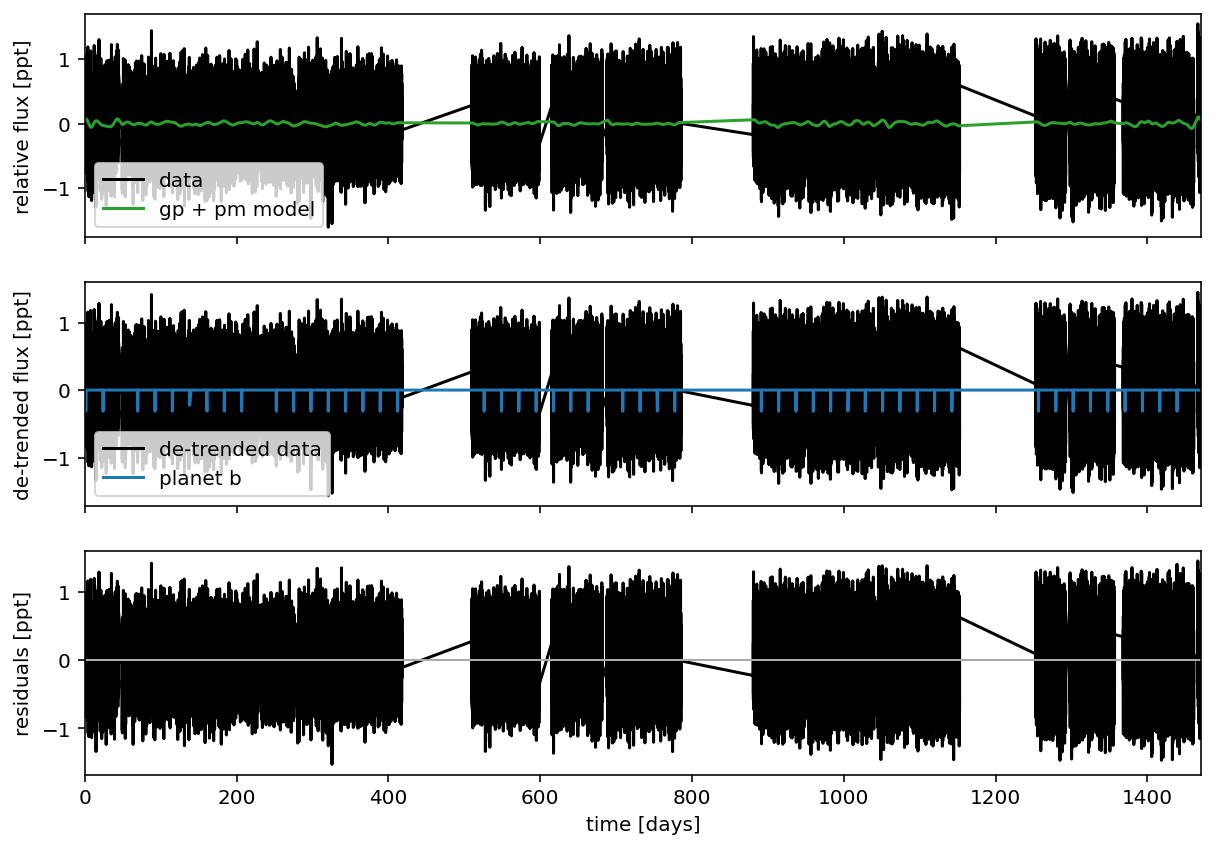

In [27]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]# + soln['pm_model']
    ax.plot(x[mask], gp_mod, color="C2", label="gp + pm model")
#     ax.plot(x[mask], soln['pm_model'], color='C3', alpha=0.7, label='pm model')
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig

plot_light_curve(map_soln0);

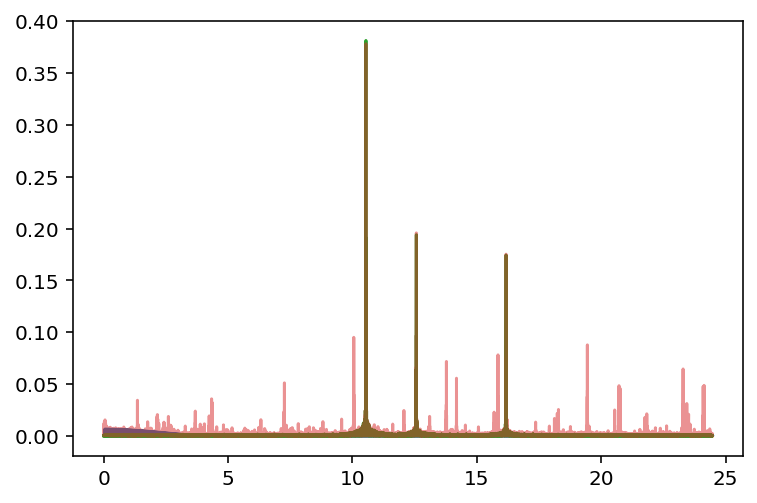

In [29]:
# from maelstrom.utils import amplitude_spectrum

# soln = map_soln0
# plt.plot(*amplitude_spectrum(x, np.sum(map_soln0["light_curves"], axis=-1)))
# plt.plot(*amplitude_spectrum(x, soln["gp_pred"]))
# plt.plot(*amplitude_spectrum(x, soln['pm_model']))

# plt.plot(*amplitude_spectrum(x, y), alpha=0.5)

Make sure my math checks out ...

In [19]:
# from maelstrom.utils import mass_function

# mf = mass_function(map_soln0['period']*u.day, np.abs(map_soln0['asini/c']) * u.s)
# mass = (mf.to(u.M_jup))**(1/3) * ((map_soln0['m_star']*u.M_sun).to(u.M_jup))**(2/3)
# mass[0]#.to(u.M_sun)

<Quantity 25.61994307 jupiterMass>

In [35]:
map_soln0

{'mean': array(0.00216895),
 'u_star_quadlimbdark__': array([-0.32195067, -0.35294729]),
 'logP': array([3.12783576]),
 't0': array([1.09622531]),
 'logr': array([-4.12205928]),
 'b_impact__': array([-0.46202177]),
 'ecs_unitdisk+interval__': array([-2.13815295e-04, -1.20882213e+00]),
 'ecc_prior_sigma_gauss_lowerbound__': array(-2.88015177),
 'ecc_prior_sigma_rayleigh_lowerbound__': array(-1.33837864),
 'ecc_prior_frac_interval__': array(0.96909792),
 'logs2': array(-1.59061974),
 'logw0': array(-0.93153699),
 'logSw4': array(-9.31491775),
 'u_star': array([0.53500633, 0.11322235]),
 'r_pl': array([0.0162111]),
 'b': array([0.39277201]),
 'ecs': array([-1.06907647e-04, -5.40180941e-01]),
 'ecc': array(0.29179546),
 'omega': array(-1.57099424),
 'ecc_prior_sigma_gauss': array(0.05612624),
 'ecc_prior_sigma_rayleigh': array(0.26227056),
 'ecc_prior_frac': array(0.72493966),
 'period': array([22.8245283]),
 'light_curves': array([[0.],
        [0.],
        [0.],
        ...,
        [0.

In [28]:

with model0:
    trace = pm.sample(
        tune=1000,
        draws=1000,
        start=map_soln0,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logSw4, logw0, logs2, ecc_prior_frac, ecc_prior_sigma_rayleigh, ecc_prior_sigma_gauss, ecs, b, logr, t0, logP, u_star, mean]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [43:02<00:00,  1.55draws/s]  


In [30]:
pm.save_trace(trace, '5202905_transit_only')

'5202905_transit_only'

In [34]:
pm.summary(trace, varnames=['mean',
 'logP',
 't0',
 'logr',
 'logs2',
 'logw0',
 'logSw4',
 'u_star',
 'r_pl',
 'b',
 'ecs',
 'ecc',
 'omega',
 'period',])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean,0.002,0.003,-0.004,0.009,0.000,0.000,1812.0,966.0,1821.0,1154.0,1.00
logP[0],3.128,0.000,3.128,3.128,0.000,0.000,1510.0,1510.0,1506.0,1166.0,1.00
t0[0],1.106,0.010,1.086,1.123,0.000,0.000,1541.0,1541.0,1523.0,1234.0,1.00
logr[0],-4.144,0.054,-4.250,-4.051,0.002,0.001,894.0,894.0,917.0,823.0,1.00
logs2,-1.590,0.006,-1.602,-1.579,0.000,0.000,2036.0,2036.0,2020.0,1405.0,1.00
logw0,-0.940,0.117,-1.155,-0.722,0.003,0.002,1821.0,1789.0,1814.0,1211.0,1.00
logSw4,-9.351,0.386,-10.061,-8.627,0.009,0.007,1704.0,1675.0,1755.0,1162.0,1.00
u_star[0],0.567,0.390,0.002,1.244,0.011,0.009,1161.0,1026.0,1146.0,915.0,1.00
u_star[1],0.113,0.382,-0.534,0.835,0.010,0.008,1372.0,1120.0,1366.0,1207.0,1.00
r_pl[0],0.016,0.001,0.014,0.017,0.000,0.000,878.0,863.0,917.0,823.0,1.00


(0.94, 1.0)

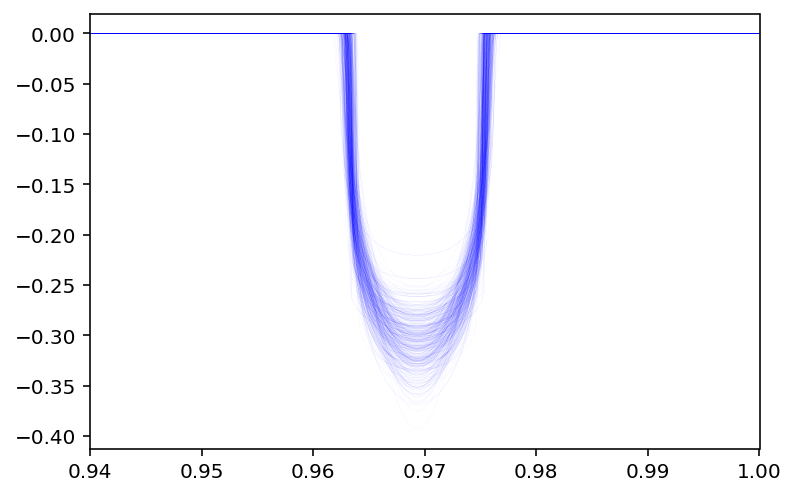

In [50]:
for samp in xo.get_samples_from_trace(trace, 500):
    phase = (x - samp['t0'] - 0.7) % samp['period'] / samp['period']
    sort = np.argsort(phase)
    plt.plot(phase[sort], samp['light_curves'][sort], c='blue', linewidth=0.1, alpha=0.1)
    
plt.xlim(0.94, 1.0)